# Packages

In [1]:
#basic packages
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# data modelling & results
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import train_test_split

#NN
import tensorflow as tf

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

#feature importance
import shap


# Script

## Error computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    #df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    #df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

## Data uploading

In [9]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [10]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [11]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1

In [12]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Model building

In [13]:
def build_model (n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8],
                 activation='relu', optimizer='Adam', regularization=None, Leaky=False):
    
    #this function build model is created only for building the NN
    #it will always initialize the weights using the strategy 'He normal' unless activation function 'selu' is selected
    
    
    if activation!='relu':
        Leaky==False
    
    
    #we create a sequential model:
    model=keras.models.Sequential()
    
    #we add the input layer with n_neurons=n_features (shape of X_train)
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #we add a hidden layer for each n_hidden with ReLU as activation function
    #this code considers the same n_neurons for each hidden layer
    for layer in range(n_hidden):
        
        if regularization=='l2':
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal',
                                            kernel_regularizer=keras.regularizers.l2(0.01)))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal',
                                            kernel_regularizer=keras.regularizers.l2(0.01)))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal',
                                           kernel_regularizer=keras.regularizers.l2(0.01)))  
        elif regularization=='l1':
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal',
                                             kernel_regularizer=keras.regularizers.l1(0.01)))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal',
                                             kernel_regularizer=keras.regularizers.l1(0.01)))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal',
                                            kernel_regularizer=keras.regularizers.l1(0.01))) 
        else:
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
        
        if Leaky:
            model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    #dropout only considered in the last layer
    if regularization=='Dropout':
        model.add(keras.layers.Dropout(rate=0.2))
        
    #we add the output layer with one neuron (we only want to predict 1 target)
    model.add(keras.layers.Dense(1))
    
    #we choose our optimizer and build it:
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    elif optimizer=='Momentum':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    elif optimizer=='Nesterov':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9)
    elif optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer=='Nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    #we compile our model with the selected optimizer and set the objective function loss='mse'
    model.compile(loss='mse', optimizer=optimizer)
    
    return model
    

In [14]:
def build_model_old (n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8],
                 activation='relu', optimizer='Adam', regularization=None, Leaky=False):
    
    #this function build model is created only for building the NN
    #it will always initialize the weights using the strategy 'He normal' unless activation function 'selu' is selected
    
    
    if activation!='relu':
        Leaky==False
    
    
    #we create a sequential model:
    model=keras.models.Sequential()
    
    #we add the input layer with n_neurons=n_features (shape of X_train)
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #we add a hidden layer for each n_hidden with ReLU as activation function
    #this code considers the same n_neurons for each hidden layer
    for layer in range(n_hidden):
        if activation=='relu':
            model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
        elif activation=='elu':
            model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
        elif activation=='selu':
            model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
        if Leaky:
            model.add(keras.layers.LeakyReLU(alpha=0.2))
            
    if regularization=='Dropout':
        model.add(keras.layers.Dropout(rate=0.2))
        
    #we add the output layer with one neuron (we only want to predict 1 target)
    model.add(keras.layers.Dense(1))
    
    #we choose our optimizer and build it:
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    elif optimizer=='Momentum':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    elif optimizer=='Nesterov':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9)
    elif optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer=='Nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    #we compile our model with the selected optimizer and set the objective function loss='mse'
    model.compile(loss='mse', optimizer=optimizer)
    
    return model
    

### Modelling NN

In [15]:
def modelling_NN (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    
    n_hidden=parameters['n_hidden']
    n_neurons=parameters['n_neurons']
    learning_rate=parameters['learning_rate']
    input_shape=X.shape[1:]
    activation=parameters['activation']
    optimizer=parameters['optimizer']
    regularization=parameters['regularization']
    Leaky=parameters['Leaky']
    
    model =build_model(n_hidden, n_neurons, learning_rate, input_shape,
                 activation, optimizer, regularization, Leaky)
 
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    

    if regularization=='Early Stopping':
        model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    else:
        model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid))
    
    
#     if plot:
#         loss_epochs_plot (history)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    y_pred_valid=model.predict(X_valid)
    
    rmse_valid=rmse(y_valid, y_pred_valid)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    print('')
    print('RMSE for validation', rmse_valid)
    print('')
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('NN modelling performed')
    
    return model

In [16]:
def modelling_NN_ES (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    
    n_hidden=parameters['n_hidden']
    n_neurons=parameters['n_neurons']
    learning_rate=parameters['learning_rate']
    input_shape=X.shape[1:]
    activation=parameters['activation']
    optimizer=parameters['optimizer']
    regularization=parameters['regularization']
    Leaky=parameters['Leaky']
    
    model =build_model(n_hidden, n_neurons, learning_rate, input_shape,
                 activation, optimizer, regularization, Leaky)
 
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    

    model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
#     if plot:
#         loss_epochs_plot (history)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
#     mse_test=model.evaluate(X_test, y_test)
#     rmse_test=np.sqrt(mse_test)
#     print('RMSE for test', rmse_test)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('NN modelling performed')
    
    return model

### Random Search NN

In [17]:
def RandomSearch_NN(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    
    #creating the model
    input_shape=X.shape[1:]
    param_distribs['input_shape']=input_shape
    keras_reg =keras.wrappers.scikit_learn.KerasRegressor(build_model, verbose=0)
    
    
    #Random Search CV
    rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3)
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    
    regularization=param_distribs['regularization']
    
    if regularization=='Early Stopping':
        rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    else:
        rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid))
    
    
    #model predicting
    
    model=rnd_search_cv.best_estimator_.model
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(rnd_search_cv.best_params_)
    print('Best score :')
    print(rnd_search_cv.best_score_)
    print('')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ NN performed')
    
    return model
    

In [18]:
def RandomSearch_NN_ES(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    #creating the model
    input_shape=X.shape[1:]
    param_distribs['input_shape']=input_shape
    keras_reg =keras.wrappers.scikit_learn.KerasRegressor(build_model, verbose=0)
    
    #Random Search CV
    rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3)
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    
    rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
    #model predicting
    
    model=rnd_search_cv.best_estimator_.model
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(rnd_search_cv.best_params_)
    print('Best score :')
    print(rnd_search_cv.best_score_)
    print('')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ NN performed')
    
    return model

### Loss plot

In [19]:
def loss_epochs_plot (history):
    
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.show
    
    return print('Loss vs. epochs plot performed')
    
    

### Model Testing

In [20]:
def model_testing (X_train, X_test, y_train, y_test, power_curve, model, plot_error):

    

    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    plot_model(model, show_shapes=True, show_layer_names=True)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    
    WS_pred=data_test['WS_pred']
    print('NN results performed')
    
    return WS_pred

### Feature importance

In [21]:
def feature_importance (X_train, X_test, model):
    
    X_t, X_f, y_t, y_f = train_test_split(X_train,y_train, test_size=0.02, random_state=12)
    
    background = X_f.copy()
    
    explainer = shap.KernelExplainer(model.predict,background)
    shap_values = explainer.shap_values(X_test,nsamples=100)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    print('Feature importance through SHAP values performed')
    

    return shap_values

In [22]:
def transform_shap (shap_values, X_test):

    v=np.array(shap_values)
    d=v.reshape(X_test.shape)
    shap_v=pd.DataFrame(d)
    
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    return k
    

# Data analysis

## Dataset2- T11

In [23]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train11.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test11.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train11.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test11.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'T1',
       'RH1', 'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'AD1',
       'tod'],
      dtype='object')

In [24]:
y_test.keys()

Index(['Target'], dtype='object')

In [25]:
X_test.head()

,WS1,WS3,WS4,WD1,WD4,WSHor,WSVer,WDHor,T1,RH1,PR1,Rain,WSH,WVeer,TI,WDVer,WD_bin,AD1,tod
0,0.499157,0.481840,0.488738,0.327588,0.389806,0.498695,0.500747,0.402230,0.477820,0.904717,0.602341,0.0,0.435078,0.498101,0.314046,0.357175,0.250,0.501449,0.762238
1,0.511992,0.529546,0.519846,0.410926,0.426596,0.509730,0.465955,0.478455,0.553334,0.826857,0.584383,0.0,0.374294,0.551549,0.714964,0.333262,0.375,0.431052,0.412587
2,0.607426,0.593543,0.574152,0.479036,0.432011,0.604143,0.617217,0.530876,0.616927,0.835353,0.170710,0.0,0.453452,0.659106,0.546230,0.399321,0.500,0.279841,0.664336
3,0.242504,0.263195,0.269806,0.501256,0.584896,0.245660,0.276392,0.549438,0.373966,0.796075,0.673673,0.0,0.437901,0.302640,0.332881,0.242406,0.500,0.631229,0.020979
4,0.456821,0.443936,0.437853,0.698402,0.672309,0.460562,0.400329,0.722298,0.458211,0.816923,0.514354,0.0,0.488508,0.428085,0.162466,0.301140,0.750,0.511753,0.797203


In [26]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

### RandomSearch

In [27]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [28]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': 'Early Stopping', 'optimizer': 'Momentum', 'n_neurons': 100, 'n_hidden': 1, 'learning_rate': 0.005, 'input_shape': 19, 'activation': 'relu', 'Leaky': True}
Best score :
-0.6488828857739767

--- 12.630461589495342 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.774 m/s as root mean
Wind MAE:  0.575 m/s in avg
Wind MAPE:  7.982 %
Power RMSE:  266.681 kW as root mean
Power MAE:  152.839 kW in avg
Power MAPE:  7.492292220539012e+17 %

Modelling errors for test set:
Wind RMSE:  0.857 m/s as root mean
Wind MAE:  0.614 m/s in avg
Wind MAPE:  10.44 %
Power RMSE:  296.199 kW as root mean
Power MAE:  163.602 kW in avg
Power MAPE:  1.8436701770959404e+18 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [30]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [31]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-0.83447552 -0.72238638 -0.82365972 -0.73007492 -1.27835931 -0.69232341
 -0.7129965  -0.99825635 -1.04885946 -0.76619754 -0.76756475 -0.96938684
         nan -0.82121068 -1.84089164 -0.84712869 -0.83041843 -0.70342112
 -0.89563972 -0.8879808 ]



Best parameters :
{'regularization': 'Dropout', 'optimizer': 'Nadam', 'n_neurons': 50, 'n_hidden': 3, 'learning_rate': 0.0003, 'input_shape': 19, 'activation': 'selu', 'Leaky': False}
Best score :
-0.6923234065373739

--- 13.332086555163066 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.813 m/s as root mean
Wind MAE:  0.592 m/s in avg
Wind MAPE:  8.801 %
Power RMSE:  290.522 kW as root mean
Power MAE:  162.478 kW in avg
Power MAPE:  9.73369940306925e+17 %

Modelling errors for test set:
Wind RMSE:  0.893 m/s as root mean
Wind MAE:  0.626 m/s in avg
Wind MAPE:  11.383 %
Power RMSE:  320.003 kW as root mean
Power MAE:  174.166 kW in avg
Power MAPE:  2.2010277810128532e+18 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [43]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [44]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
163/163 [==============================] - 0s 3ms/step - loss: 9.7217 - val_loss: 1.0910
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 0.9004 - val_loss: 0.9157
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 0.8313 - val_loss: 0.8591
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7774 - val_loss: 0.8919
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7591 - val_loss: 0.8188
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7486 - val_loss: 0.8027
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7430 - val_loss: 0.7799
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7168 - val_loss: 0.7829
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7055 - val_loss: 0.7872
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7109 - val_lo

In [38]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'selu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [39]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
163/163 [==============================] - 0s 3ms/step - loss: 12.7749 - val_loss: 1.1144
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 0.9966 - val_loss: 0.9636
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 0.8642 - val_loss: 0.8922
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 0.8107 - val_loss: 0.8763
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 0.8087 - val_loss: 0.8730
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7871 - val_loss: 0.8786
Epoch 7/100
163/163 [==============================] - 0s 1ms/step - loss: 0.7867 - val_loss: 0.8350
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7784 - val_loss: 0.8225
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7770 - val_loss: 0.8755
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 0.7652 - val_l

### Model saving

{'regularization': 'Early Stopping', 'optimizer': 'Momentum', 'n_neurons': 100, 'n_hidden': 1, 'learning_rate': 0.005, 'input_shape': 19, 'activation': 'relu', 'Leaky': True}

MAPE wind: 10.44 %

In [29]:
model.save('T11_ANN1.h5')

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE wind: 9.976 %

In [42]:
model.save('T11_ANN2.h5')

### Model testing

In [27]:
model=keras.models.load_model('T11_ANN2.h5')

In [28]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.715 m/s as root mean
Wind MAE:  0.53 m/s in avg
Wind MAPE:  7.056 %
Power RMSE:  253.19 kW as root mean
Power MAE:  141.847 kW in avg
Power MAPE:  3.682586310545441e+17 %

Modelling errors for test set:
Wind RMSE:  0.833 m/s as root mean
Wind MAE:  0.596 m/s in avg
Wind MAPE:  9.976 %
Power RMSE:  307.208 kW as root mean
Power MAE:  165.112 kW in avg
Power MAPE:  1.5128036862987113e+18 %

Showing the results of the modelling: 
NN results performed


In [29]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_T11.csv')

file ANN_T11.csv saved in \Results_ folder


### Feature importance

Using 130 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2782 [00:00<?, ?it/s]

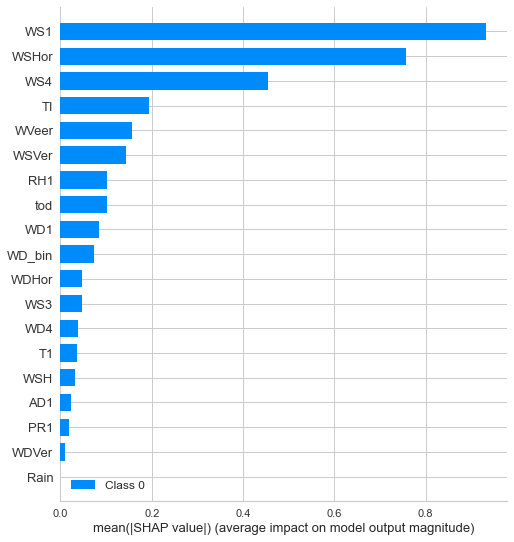

Feature importance through SHAP values performed


In [47]:
shap_values=feature_importance (X_train, X_test, model)

In [48]:
k=transform_shap (shap_values, X_test)

In [49]:
X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'T1',
       'RH1', 'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'AD1',
       'tod'],
      dtype='object')

In [51]:
k

,variables,SHAP_abs
0,WS1,0.931588
1,WS3,0.047656
2,WS4,0.454398
3,WD1,0.083622
4,WD4,0.039101
5,WSHor,0.756692
6,WSVer,0.144684
7,WDHor,0.048118
8,T1,0.036579
9,RH1,0.102348


## Dataset2- T17

In [52]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train17.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test17.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train17.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test17.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'PR1',
       'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [53]:
y_test.keys()

Index(['Target'], dtype='object')

In [54]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V112.csv')

### Random Search

In [55]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [56]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [ -1.07578381  -0.39619265 -16.41513602  -0.49583897  -0.47011769
  -0.53511881  -0.6136086  -16.43231742  -1.04724256          nan
  -0.40382962 -86.82775116          nan  -0.5123837   -0.46735646
  -0.44322575  -0.3673082   -0.4475245   -7.31817595  -0.48747708]



Best parameters :
{'regularization': 'Dropout', 'optimizer': 'Nesterov', 'n_neurons': 100, 'n_hidden': 2, 'learning_rate': 0.003, 'input_shape': 16, 'activation': 'relu', 'Leaky': False}
Best score :
-0.36730819940567017

--- 9.923941997687022 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.566 m/s as root mean
Wind MAE:  0.435 m/s in avg
Wind MAPE:  4.637 %
Power RMSE:  234.791 kW as root mean
Power MAE:  149.818 kW in avg
Power MAPE:  10.28 %

Modelling errors for test set:
Wind RMSE:  0.581 m/s as root mean
Wind MAE:  0.453 m/s in avg
Wind MAPE:  4.874 %
Power RMSE:  232.359 kW as root mean
Power MAE:  153.256 kW in avg
Power MAPE:  10.934 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [63]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [64]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-0.55291259 -2.70085859 -0.51208058 -0.50634738 -0.45095621 -0.47614641
 -0.40602157 -0.39175396 -0.45050852 -0.65759597 -0.45821362 -0.58228477
 -0.41942017 -0.51744967 -0.4513313  -0.43145026 -0.58018708 -2.89246694
         nan -1.21432499]



Best parameters :
{'regularization': 'Early Stopping', 'optimizer': 'Nesterov', 'n_neurons': 90, 'n_hidden': 3, 'learning_rate': 0.001, 'input_shape': 16, 'activation': 'elu', 'Leaky': True}
Best score :
-0.3917539616425832

--- 9.595975708961486 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.575 m/s as root mean
Wind MAE:  0.445 m/s in avg
Wind MAPE:  4.869 %
Power RMSE:  246.565 kW as root mean
Power MAE:  156.993 kW in avg
Power MAPE:  11.484 %

Modelling errors for test set:
Wind RMSE:  0.601 m/s as root mean
Wind MAE:  0.475 m/s in avg
Wind MAPE:  5.254 %
Power RMSE:  245.834 kW as root mean
Power MAE:  162.641 kW in avg
Power MAPE:  12.508 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [69]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [70]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
110/110 [==============================] - 0s 3ms/step - loss: 8.3426 - val_loss: 0.6730
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 0.6003 - val_loss: 0.5343
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 0.5300 - val_loss: 0.4999
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4988 - val_loss: 0.5281
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4822 - val_loss: 0.4818
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4788 - val_loss: 0.4518
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4703 - val_loss: 0.4453
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4468 - val_loss: 0.5059
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4419 - val_loss: 0.4625
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4321 - val_lo

In [61]:
parameters={
    'n_hidden':2,
    'n_neurons': 100,
    'learning_rate':0.003,
    'activation':'relu',
    'optimizer':'Nesterov',
    'regularization':'Dropout',
    'Leaky':True
}

In [62]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
110/110 [==============================] - 1s 5ms/step - loss: 2.8698 - val_loss: 0.6813
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 1.1900 - val_loss: 0.4880
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 1.0417 - val_loss: 0.5568
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 0.9791 - val_loss: 0.4851
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 0.8464 - val_loss: 0.5179
Epoch 6/100
110/110 [==============================] - 1s 5ms/step - loss: 0.8174 - val_loss: 1.0815
Epoch 7/100
110/110 [==============================] - 0s 3ms/step - loss: 0.8166 - val_loss: 0.4626
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - loss: 0.7592 - val_loss: 1.1616
Epoch 9/100
110/110 [==============================] - 0s 4ms/step - loss: 0.7577 - val_loss: 0.4785
Epoch 10/100
110/110 [==============================] - 0s 5ms/step - loss: 0.6805 - val_lo

Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4182 - val_loss: 0.3989
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4277 - val_loss: 0.3652
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4107 - val_loss: 0.5197
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4074 - val_loss: 0.3761
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4116 - val_loss: 0.4015
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4198 - val_loss: 0.5140
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4180 - val_loss: 0.3742
Epoch 86/100
110/110 [==============================] - 0s 3ms/step - loss: 0.4064 - val_loss: 0.4334
Epoch 87/100
110/110 [==============================] - 0s 4ms/step - loss: 0.4106 - val_loss: 0.5014
Epoch 88/100
110/110 [==============================] - 0s 3ms/step - loss: 0.4019

In [72]:
parameters={
    'n_hidden':3,
    'n_neurons': 90,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Nesterov',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [73]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
110/110 [==============================] - 0s 3ms/step - loss: 3.2105 - val_loss: 0.8977
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 0.6046 - val_loss: 0.5568
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 0.5471 - val_loss: 0.5967
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 0.5223 - val_loss: 0.4763
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 0.5063 - val_loss: 0.5109
Epoch 6/100
110/110 [==============================] - 0s 1ms/step - loss: 0.4853 - val_loss: 0.7783
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4855 - val_loss: 0.4559
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4583 - val_loss: 0.4490
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4523 - val_loss: 0.4772
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4680 - val_lo

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE power: 10.4%

In [71]:
model.save('T17_ANN1.h5')

In [65]:
# model.save('T17_ANN2.h5')

### Model testing

In [74]:
model=keras.models.load_model('T17_ANN1.h5')

In [75]:
model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.54 m/s as root mean
Wind MAE:  0.414 m/s in avg
Wind MAPE:  4.398 %
Power RMSE:  228.391 kW as root mean
Power MAE:  145.415 kW in avg
Power MAPE:  9.502 %

Modelling errors for test set:
Wind RMSE:  0.576 m/s as root mean
Wind MAE:  0.452 m/s in avg
Wind MAPE:  4.831 %
Power RMSE:  235.775 kW as root mean
Power MAE:  155.627 kW in avg
Power MAPE:  10.482 %

Showing the results of the modelling: 
NN results performed


### Feature importance

  0%|          | 0/1874 [00:00<?, ?it/s]

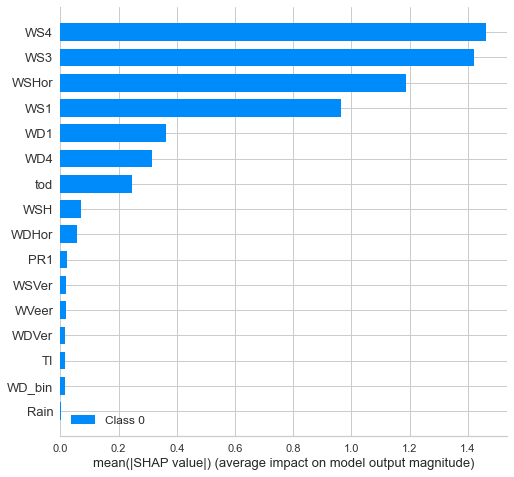

Feature importance through SHAP values performed


In [76]:
shap_values=feature_importance (X_train, X_test, model)

In [77]:
k=transform_shap (shap_values, X_test)

In [78]:
k

,variables,SHAP_abs
0,WS1,0.965660
1,WS3,1.422564
2,WS4,1.460906
3,WD1,0.362853
4,WD4,0.315924
5,WSHor,1.187850
6,WSVer,0.018416
7,WDHor,0.055578
8,PR1,0.021968
9,Rain,0.003067


## Dataset2- T22

In [23]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train22.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test22.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train22.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test22.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [24]:
y_test.keys()

Index(['Target'], dtype='object')

In [25]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

### Random Search

In [29]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [30]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': 'Dropout', 'optimizer': 'Nesterov', 'n_neurons': 80, 'n_hidden': 3, 'learning_rate': 0.001, 'input_shape': 17, 'activation': 'relu', 'Leaky': True}
Best score :
-0.6610205769538879

--- 9.078933183352152 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.707 m/s as root mean
Wind MAE:  0.538 m/s in avg
Wind MAPE:  7.318 %
Power RMSE:  317.923 kW as root mean
Power MAE:  213.835 kW in avg
Power MAPE:  7.421315656754958e+16 %

Modelling errors for test set:
Wind RMSE:  0.741 m/s as root mean
Wind MAE:  0.559 m/s in avg
Wind MAPE:  7.467 %
Power RMSE:  348.899 kW as root mean
Power MAE:  227.326 kW in avg
Power MAPE:  24.052 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [31]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [32]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-1.37643977 -1.69325157 -1.64425476 -1.00734305 -0.82106346 -0.83543595
 -0.89177605 -1.17182251 -0.69177105 -0.77259185 -1.05052233 -0.96071255
 -0.71196856 -0.72100133         nan -0.78692005 -0.82343479 -0.99675479
 -0.96730433 -1.00919571]



Best parameters :
{'regularization': 'Dropout', 'optimizer': 'Nesterov', 'n_neurons': 30, 'n_hidden': 2, 'learning_rate': 0.003, 'input_shape': 17, 'activation': 'relu', 'Leaky': True}
Best score :
-0.6917710502942404

--- 8.941617663701376 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.844 m/s as root mean
Wind MAE:  0.646 m/s in avg
Wind MAPE:  8.645 %
Power RMSE:  379.044 kW as root mean
Power MAE:  251.963 kW in avg
Power MAPE:  7.349464790500515e+16 %

Modelling errors for test set:
Wind RMSE:  0.821 m/s as root mean
Wind MAE:  0.621 m/s in avg
Wind MAPE:  8.116 %
Power RMSE:  378.153 kW as root mean
Power MAE:  242.28 kW in avg
Power MAPE:  24.985 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [37]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [38]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
101/101 [==============================] - 0s 4ms/step - loss: 5.0496 - val_loss: 1.4375
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 1.2842 - val_loss: 1.2392
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 1.0901 - val_loss: 1.0316
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 1.0301 - val_loss: 0.9676
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9400 - val_loss: 0.9169
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 0.8907 - val_loss: 0.7976
Epoch 7/100
101/101 [==============================] - 0s 2ms/step - loss: 0.8351 - val_loss: 0.7823
Epoch 8/100
101/101 [==============================] - 0s 2ms/step - loss: 0.8359 - val_loss: 0.7433
Epoch 9/100
101/101 [==============================] - 0s 3ms/step - loss: 0.8118 - val_loss: 0.9222
Epoch 10/100
101/101 [==============================] - 0s 2ms/step - loss: 0.8290 - val_lo

In [33]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [34]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
101/101 [==============================] - 1s 7ms/step - loss: 6.6392 - val_loss: 1.4481
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 1.3232 - val_loss: 1.2216
Epoch 3/100
101/101 [==============================] - 0s 4ms/step - loss: 1.1765 - val_loss: 1.0295
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 1.0345 - val_loss: 0.9601
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.9520 - val_loss: 0.8452
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 0.8963 - val_loss: 0.7952
Epoch 7/100
101/101 [==============================] - 0s 4ms/step - loss: 0.8539 - val_loss: 0.7890
Epoch 8/100
101/101 [==============================] - 0s 4ms/step - loss: 0.8091 - val_loss: 1.0624
Epoch 9/100
101/101 [==============================] - 0s 4ms/step - loss: 0.7757 - val_loss: 0.7210
Epoch 10/100
101/101 [==============================] - 0s 5ms/step - loss: 0.7285 - val_lo

In [35]:
parameters={
    'n_hidden':2,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'relu',
    'optimizer':'Nesterov',
    'regularization':'Dropout',
    'Leaky':True
}

In [36]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
101/101 [==============================] - 0s 3ms/step - loss: 4.7634 - val_loss: 1.3797
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 2.0376 - val_loss: 1.0884
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 1.7800 - val_loss: 1.0608
Epoch 4/100
101/101 [==============================] - 0s 1ms/step - loss: 1.7802 - val_loss: 0.9697
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 1.6685 - val_loss: 0.9390
Epoch 6/100
101/101 [==============================] - 0s 1ms/step - loss: 1.5860 - val_loss: 0.9274
Epoch 7/100
101/101 [==============================] - 0s 1ms/step - loss: 1.5561 - val_loss: 0.9059
Epoch 8/100
101/101 [==============================] - 0s 2ms/step - loss: 1.4866 - val_loss: 0.8839
Epoch 9/100
101/101 [==============================] - 0s 2ms/step - loss: 1.4041 - val_loss: 0.8614
Epoch 10/100
101/101 [==============================] - 0s 2ms/step - loss: 1.3642 - val_lo

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE wind: 20.8%

In [28]:
model.save('T22_ANN1.h5')

### Model testing

In [39]:
model=keras.models.load_model('T22_ANN1.h5')

In [40]:
model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.65 m/s as root mean
Wind MAE:  0.501 m/s in avg
Wind MAPE:  6.594 %
Power RMSE:  293.747 kW as root mean
Power MAE:  199.892 kW in avg
Power MAPE:  3.4799457333710576e+16 %

Modelling errors for test set:
Wind RMSE:  0.73 m/s as root mean
Wind MAE:  0.551 m/s in avg
Wind MAPE:  7.162 %
Power RMSE:  340.821 kW as root mean
Power MAE:  223.019 kW in avg
Power MAPE:  20.814 %

Showing the results of the modelling: 
NN results performed


### Feature importance

  0%|          | 0/1722 [00:00<?, ?it/s]

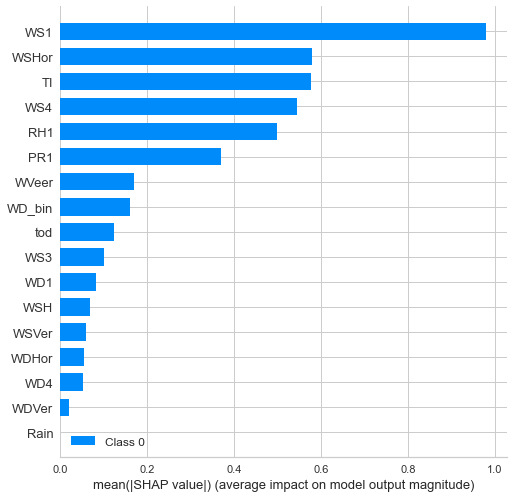

Feature importance through SHAP values performed


In [41]:
shap_values=feature_importance (X_train, X_test, model)

In [42]:
k=transform_shap (shap_values, X_test)

In [43]:
k

,variables,SHAP_abs
0,WS1,0.979029
1,WS3,0.101241
2,WS4,0.544211
3,WD1,0.082908
4,WD4,0.052143
5,WSHor,0.578861
6,WSVer,0.059481
7,WDHor,0.054750
8,RH1,0.499326
9,PR1,0.370266
